<a href="https://colab.research.google.com/github/ChloeCrozier/cevac_facillities/blob/main/mapping_scripts/cevac_data_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import pandas as pd
from tabulate import tabulate
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [4]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('/content/workorder.csv')

<ipython-input-4-336242827ed7>:2: DtypeWarning: Columns (19,32,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/workorder.csv')


In [5]:
selectedColumns = df[['WO_WORKORDER', 'WO_BARCODE', 'WO_STATUS', 'WO_ENTRY_DATE', 'WO_DESC', 'WO_TYPE_WITH_DESCRIPTION', 'WO_CATEGORY_WITH_DESC', 'WO_CREATED_BY', 'WO_ORGANIZATION_WITH_DESC', 'WO_REQUESTOR_WITH_DESC', 'WO_CONTACT_PHONE', 'WO_CONTACT_EMAIL', 'WO_REGION_DESC', 'WO_FACILITY', 'WO_BUILDING', 'WO_BUILDING_DESC', 'WO_SHOP', 'WO_SHOP_DESC', 'WO_SHOP_PERSON_WITH_DESC', 'WO_STATUS_DATE']]
selectedColumns

,WO_WORKORDER,WO_BARCODE,WO_STATUS,WO_ENTRY_DATE,WO_DESC,WO_TYPE_WITH_DESCRIPTION,WO_CATEGORY_WITH_DESC,WO_CREATED_BY,WO_ORGANIZATION_WITH_DESC,WO_REQUESTOR_WITH_DESC,WO_CONTACT_PHONE,WO_CONTACT_EMAIL,WO_REGION_DESC,WO_FACILITY,WO_BUILDING,WO_BUILDING_DESC,WO_SHOP,WO_SHOP_DESC,WO_SHOP_PERSON_WITH_DESC,WO_STATUS_DATE
0,25-672166,*25-672166*,OPEN,14-Aug-24,EC CHILL WATER FACILITY - RM 100 - REPLACE VF...,MAINTENANCE (MAINTENANCE WORK),CORRECTIVE (CORRECTIVE / ROUTINE MAINTENANCE),DLEE7,5801 (CAMPUS UTILITIES),SFEAGAN (SCOTT LEE FEAGAN),(864) 643-6418,NaN,CLEMSON UNIVERSITY,MAIN_CAMPUS,376,EC CHILL WATER FACILITY,UT_CHILLER,UTILITY CHILLER SHOP,NaN,14-Aug-24
1,24-657268,*24-657268*,OPEN,7-Jun-24,"EC CHILL WATER, QUARTERLY, AIR DRYER, ADD, INS...",MAINTENANCE (MAINTENANCE WORK),PREVENTIVE (PREVENTIVE MAINTENANCE),DTHOMSO,NaN,NaN,NaN,NaN,CLEMSON UNIVERSITY,MAIN_CAMPUS,376,EC CHILL WATER FACILITY,UT_ STEAM_PLANT,UTILITY STEAM PLANT,NaN,7-Jun-24
2,24-657270,*24-657270*,OPEN,7-Jun-24,"EC CHILL WATER, MONTHLY, AIR COMPRESSOR, CMP, ...",MAINTENANCE (MAINTENANCE WORK),PREVENTIVE (PREVENTIVE MAINTENANCE),DTHOMSO,NaN,NaN,NaN,NaN,CLEMSON UNIVERSITY,MAIN_CAMPUS,376,EC CHILL WATER FACILITY,UT_ STEAM_PLANT,UTILITY STEAM PLANT,NaN,7-Jun-24
3,24-657273,*24-657273*,OPEN,7-Jun-24,"EC CHILL WATER, MONTHLY, AIR INTAKE, AIF, INSP...",MAINTENANCE (MAINTENANCE WORK),PREVENTIVE (PREVENTIVE MAINTENANCE),DTHOMSO,NaN,NaN,NaN,NaN,CLEMSON UNIVERSITY,MAIN_CAMPUS,376,EC CHILL WATER FACILITY,UT_ STEAM_PLANT,UTILITY STEAM PLANT,NaN,7-Jun-24
4,24-657293,*24-657293*,OPEN,7-Jun-24,"EC CHILL WATER, MONTHLY, FIRE EXTINGUISHER, FI...",MAINTENANCE (MAINTENANCE WORK),PREVENTIVE (PREVENTIVE MAINTENANCE),DTHOMSO,NaN,NaN,NaN,NaN,CLEMSON UNIVERSITY,MAIN_CAMPUS,376,EC CHILL WATER FACILITY,UT_ STEAM_PLANT,UTILITY STEAM PLANT,NaN,7-Jun-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16438,25-668515,*25-668515*,CLOSED,26-Jul-24,GENTRY HALL - WE HAVE BLACK ANTS IN THE KITCH...,MAINTENANCE (MAINTENANCE WORK),CORRECTIVE (CORRECTIVE / ROUTINE MAINTENANCE),DLEE7,UNKN (QUASI-ORGANIZATION FOR THE PURPOSE OF CL...,NaN,(864) 656-5258,NaN,CLEMSON UNIVERSITY,MAIN_CAMPUS,4040,GENTRY HALL,MAINT_CONSTRUCTION,MAINTENANCE CONSTRUCTION SHOP,051882 (BENJAMIN BOTTOMS),17-Aug-24
16439,25-669086,*25-669086*,CLOSED,1-Aug-24,GENTRY HALL - RM 220 - THE ANTS FROM DOWNSTAI...,MAINTENANCE (MAINTENANCE WORK),CORRECTIVE (CORRECTIVE / ROUTINE MAINTENANCE),CKIRBY2,UNKN (QUASI-ORGANIZATION FOR THE PURPOSE OF CL...,NaN,(864) 656-5258,NaN,CLEMSON UNIVERSITY,MAIN_CAMPUS,4040,GENTRY HALL,MAINT_CONSTRUCTION,MAINTENANCE CONSTRUCTION SHOP,051882 (BENJAMIN BOTTOMS),17-Aug-24
16440,25-669785,*25-669785*,CLOSED,5-Aug-24,GENTRY HALL - RM 102 - LONG PORTION OF RAILIN...,MAINTENANCE (MAINTENANCE WORK),CORRECTIVE (CORRECTIVE / ROUTINE MAINTENANCE),JGILLI5,UNKN (QUASI-ORGANIZATION FOR THE PURPOSE OF CL...,NaN,(864) 656-5258,NaN,CLEMSON UNIVERSITY,MAIN_CAMPUS,4040,GENTRY HALL,MAINT_CONSTRUCTION,MAINTENANCE CONSTRUCTION SHOP,NaN,7-Aug-24
16441,24-654556,*24-654556*,CLOSED,30-May-24,GENTRY HALL - RM 111 - LADIES RR SINK IS NOT ...,MAINTENANCE (MAINTENANCE WORK),CORRECTIVE (CORRECTIVE / ROUTINE MAINTENANCE),JGILLI5,UNKN (QUASI-ORGANIZATION FOR THE PURPOSE OF CL...,NaN,(864) 656-7113,NaN,CLEMSON UNIVERSITY,MAIN_CAMPUS,4040,GENTRY HALL,MAINT_PERIMETER,MAINTENANCE PERIMETER AREA,NaN,14-Jun-24



Questions
1. Are we training the model on tickets that have closed or both tickets that are open and closed?
2. Does the creator of the ticket matter when training the model?
3. Does the requestor matter?

Planned model desgin:
* Train the data on the the decription of a Work Order (WO), Region, Building, Shop, and Shop Person.
* The model will in-take all of the same information, but it will isntead predict the Shop Person (output instead of input).

In [6]:
openWOs = selectedColumns[selectedColumns['WO_STATUS'] == 'OPEN']
closedWOs = selectedColumns[selectedColumns['WO_STATUS'] == 'CLOSED']

In [19]:
closedWOs = closedWOs.dropna(subset=['WO_SHOP'])
closedWOs

,WO_WORKORDER,WO_BARCODE,WO_STATUS,WO_ENTRY_DATE,WO_DESC,WO_TYPE_WITH_DESCRIPTION,WO_CATEGORY_WITH_DESC,WO_CREATED_BY,WO_ORGANIZATION_WITH_DESC,WO_REQUESTOR_WITH_DESC,WO_CONTACT_PHONE,WO_CONTACT_EMAIL,WO_REGION_DESC,WO_FACILITY,WO_BUILDING,WO_BUILDING_DESC,WO_SHOP,WO_SHOP_DESC,WO_SHOP_PERSON_WITH_DESC,WO_STATUS_DATE
11,24-662547,*24-662547*,CLOSED,28-Jun-24,"EC CHILL WATER PLANT, MONTHLY, EMERGENCY EGRES...",MAINTENANCE (MAINTENANCE WORK),PREVENTIVE (PREVENTIVE MAINTENANCE),DTHOMSO,NaN,NaN,NaN,NaN,CLEMSON UNIVERSITY,MAIN_CAMPUS,376,EC CHILL WATER FACILITY,UT_CHILLER,UTILITY CHILLER SHOP,NaN,2-Aug-24
12,25-663726,*25-663726*,CLOSED,3-Jul-24,"EC CHILL WATER, YEARLY, EYE WASH STATION / EME...",MAINTENANCE (MAINTENANCE WORK),PREVENTIVE (PREVENTIVE MAINTENANCE),DTHOMSO,NaN,NaN,NaN,NaN,CLEMSON UNIVERSITY,MAIN_CAMPUS,376,EC CHILL WATER FACILITY,UT_CHILLER,UTILITY CHILLER SHOP,NaN,2-Aug-24
14,25-668458,*25-668458*,CLOSED,26-Jul-24,"EC CHILL WATER PLANT, MONTHLY, EMERGENCY EGRES...",MAINTENANCE (MAINTENANCE WORK),PREVENTIVE (PREVENTIVE MAINTENANCE),DTHOMSO,NaN,NaN,NaN,NaN,CLEMSON UNIVERSITY,MAIN_CAMPUS,376,EC CHILL WATER FACILITY,UT_CHILLER,UTILITY CHILLER SHOP,NaN,2-Aug-24
18,25-664258,*25-664258*,CLOSED,10-Jul-24,HYDRAULIC LAB - THEY'RE GETTING READY TO DEMO ...,MAINTENANCE (MAINTENANCE WORK),CORRECTIVE (CORRECTIVE / ROUTINE MAINTENANCE),JGILLI5,0951 (SCHOOL OF CE & EEES),SBLACK2 (SCOTT BLACK),NaN,NaN,CLEMSON UNIVERSITY,MAIN_CAMPUS,380,HYDRAULIC TEST BASIN #2,SS,SUPPORT SERVICES,NaN,1-Aug-24
19,24-659525,*24-659525*,CLOSED,14-Jun-24,"HYDRAULIC TEST BASIN #2, YEARLY, BUILDING INSP...",MAINTENANCE (MAINTENANCE WORK),PREVENTIVE (PREVENTIVE MAINTENANCE),DTHOMSO,NaN,NaN,NaN,NaN,CLEMSON UNIVERSITY,MAIN_CAMPUS,380,HYDRAULIC TEST BASIN #2,MAINT_PERIMETER,MAINTENANCE PERIMETER AREA,NaN,8-Aug-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16437,25-667185,*25-667185*,CLOSED,22-Jul-24,GENTRY HALL - ISSUE WITH LIGHTS IN ONE OF THE...,MAINTENANCE (MAINTENANCE WORK),CORRECTIVE (CORRECTIVE / ROUTINE MAINTENANCE),DLEE7,UNKN (QUASI-ORGANIZATION FOR THE PURPOSE OF CL...,NaN,(864) 656-0075,NaN,CLEMSON UNIVERSITY,MAIN_CAMPUS,4040,GENTRY HALL,MAINT_DINING,DINING AND RESIDENTIAL ELECTRICAL,NaN,1-Aug-24
16438,25-668515,*25-668515*,CLOSED,26-Jul-24,GENTRY HALL - WE HAVE BLACK ANTS IN THE KITCH...,MAINTENANCE (MAINTENANCE WORK),CORRECTIVE (CORRECTIVE / ROUTINE MAINTENANCE),DLEE7,UNKN (QUASI-ORGANIZATION FOR THE PURPOSE OF CL...,NaN,(864) 656-5258,NaN,CLEMSON UNIVERSITY,MAIN_CAMPUS,4040,GENTRY HALL,MAINT_CONSTRUCTION,MAINTENANCE CONSTRUCTION SHOP,051882 (BENJAMIN BOTTOMS),17-Aug-24
16439,25-669086,*25-669086*,CLOSED,1-Aug-24,GENTRY HALL - RM 220 - THE ANTS FROM DOWNSTAI...,MAINTENANCE (MAINTENANCE WORK),CORRECTIVE (CORRECTIVE / ROUTINE MAINTENANCE),CKIRBY2,UNKN (QUASI-ORGANIZATION FOR THE PURPOSE OF CL...,NaN,(864) 656-5258,NaN,CLEMSON UNIVERSITY,MAIN_CAMPUS,4040,GENTRY HALL,MAINT_CONSTRUCTION,MAINTENANCE CONSTRUCTION SHOP,051882 (BENJAMIN BOTTOMS),17-Aug-24
16440,25-669785,*25-669785*,CLOSED,5-Aug-24,GENTRY HALL - RM 102 - LONG PORTION OF RAILIN...,MAINTENANCE (MAINTENANCE WORK),CORRECTIVE (CORRECTIVE / ROUTINE MAINTENANCE),JGILLI5,UNKN (QUASI-ORGANIZATION FOR THE PURPOSE OF CL...,NaN,(864) 656-5258,NaN,CLEMSON UNIVERSITY,MAIN_CAMPUS,4040,GENTRY HALL,MAINT_CONSTRUCTION,MAINTENANCE CONSTRUCTION SHOP,NaN,7-Aug-24


In [42]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [43]:
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stop words
    return text

In [52]:
X = closedWOs['WO_DESC']
y = closedWOs['WO_SHOP']

# X_cleaned = X.apply(clean_text)

X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [45]:
set(list(y))

{'CAP_PROJ',
 'CU',
 'CU_ RECYCLE',
 'CU_ICAR',
 'ES',
 'LS',
 'LS_ARBOR',
 'LS_MECHANIC',
 'MAINT_AFTER_HOURS',
 'MAINT_BUILDING_SECURITY',
 'MAINT_CENTRAL',
 'MAINT_CONSTRUCTION',
 'MAINT_DINING',
 'MAINT_DOUTHIT',
 'MAINT_HVAC',
 'MAINT_LIFE_SAFETY',
 'MAINT_PERIMETER',
 'RES_CUSTODIAL_EAST',
 'RES_CUSTODIAL_MAINT',
 'RES_CUSTODIAL_NORTH',
 'RES_CUSTODIAL_WEST',
 'SS',
 'UT_ STEAM_PLANT',
 'UT_CHILLER',
 'UT_CONSTRUCTION',
 'UT_HIGH_VOLTAGE'}

In [53]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

LogisticRegression(max_iter=1000)

In [54]:
y_pred = model.predict(X_test_vec)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7737719693555656


In [55]:
new_wo_desc = "hvac is leaking in douthit"
new_wo_desc_vec = vectorizer.transform([new_wo_desc])
predicted_shop = model.predict(new_wo_desc_vec)[0]
print(f"Predicted Shop for '{new_wo_desc}': {predicted_shop}")

Predicted Shop for 'hvac is leaking in douthit': SS


In [57]:
open_wo_desc = openWOs['WO_DESC']
open_wo_desc_cleaned = open_wo_desc.apply(clean_text)

open_wo_desc_vec = vectorizer.transform(open_wo_desc_cleaned)

predicted_shops_open = model.predict(open_wo_desc_vec)

openWOs['predicted_shop'] = predicted_shops_open

<ipython-input-57-5fb099561af6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  openWOs['predicted_shop'] = predicted_shops_open


In [58]:
openWOs.to_csv('open_workorders_with_predictions.csv', index=False)
print(openWOs[['WO_DESC', 'predicted_shop']])

                                                 WO_DESC   predicted_shop
0      EC CHILL WATER FACILITY  - RM 100 - REPLACE VF...               SS
1      EC CHILL WATER, QUARTERLY, AIR DRYER, ADD, INS...       MAINT_HVAC
2      EC CHILL WATER, MONTHLY, AIR COMPRESSOR, CMP, ...               SS
3      EC CHILL WATER, MONTHLY, AIR INTAKE, AIF, INSP...    MAINT_CENTRAL
4      EC CHILL WATER, MONTHLY, FIRE EXTINGUISHER, FI...    MAINT_CENTRAL
...                                                  ...              ...
16429  GENTRY, YEARLY, WATER HEATER, HWH, INSPECTION,...  MAINT_PERIMETER
16430  GENTRY, MONTHLY, FAN COIL UNIT, FCU, INSPECT F...  MAINT_PERIMETER
16431  GENTRY, MONTHLY, FIRE EXTINGUISHER, FIR, INSPE...  MAINT_PERIMETER
16432  GENTRY, MONTHLY, EMERGENCY EGRESS LIGHTING, EE...  MAINT_PERIMETER
16442  CUP 4003771 - DAC CARD ACCESS/SECURITY CAMERA ...               SS

[5178 rows x 2 columns]


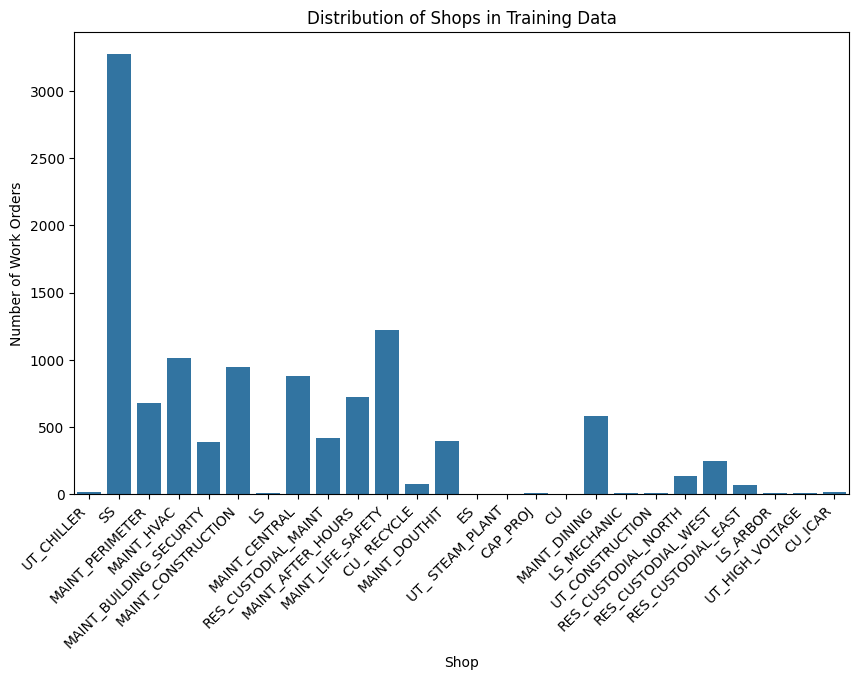

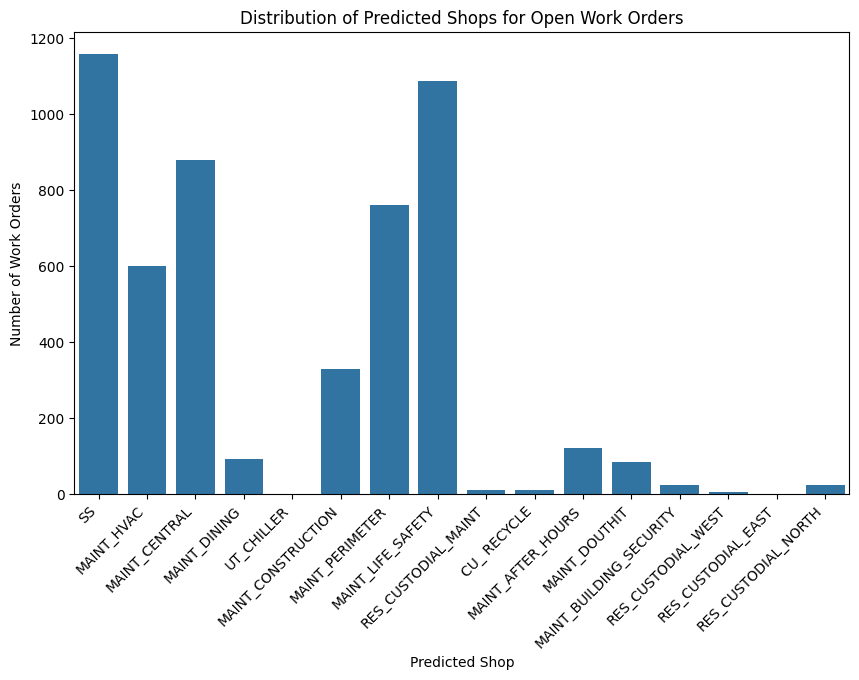

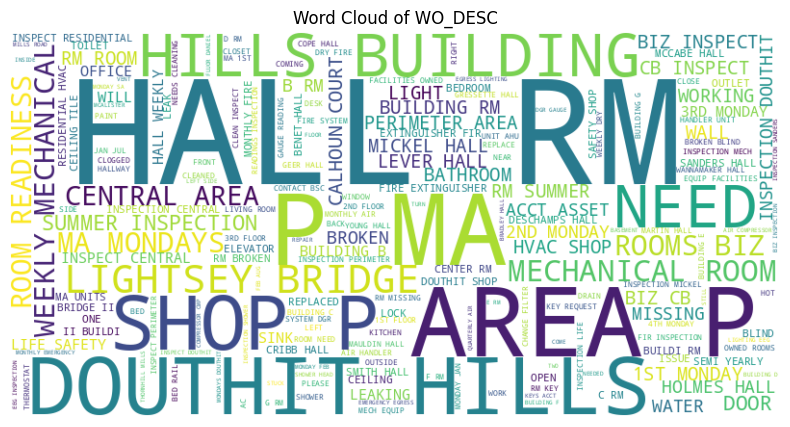

In [66]:
plt.figure(figsize=(10, 6))
sns.countplot(x='WO_SHOP', data=closedWOs)
plt.title('Distribution of Shops in Training Data')
plt.xlabel('Shop')
plt.ylabel('Number of Work Orders')
plt.xticks(rotation=45, ha='right')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='predicted_shop', data=openWOs)
plt.title('Distribution of Predicted Shops for Open Work Orders')
plt.xlabel('Predicted Shop')
plt.ylabel('Number of Work Orders')
plt.xticks(rotation=45, ha='right')
plt.show()

text = " ".join(closedWOs['WO_DESC'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of WO_DESC')
plt.show()